In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.1 MB/s eta 0:00:00


In [3]:
pip install deepface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.5 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=f07b06c088d77b3c696abd741daf4e8686b1cfa6763800df82d16d247d6f5e6a
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire


In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

In [49]:
from google.colab import drive
drive.mount('/content/drive')


data_dir = '/content/drive/MyDrive/AI/faces'

# Kiểm tra số lượng ảnh mỗi lớp
def count_images_per_class(directory):
    counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            counts[class_name] = len(os.listdir(class_path))
    return counts

print("Image count per class:", count_images_per_class(data_dir))

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    shear_range=0.1,
    zoom_range=[0.8, 1.2],
    horizontal_flip=True,
    rotation_range=32,
    width_shift_range=0.05,
    height_shift_range=0.05,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    channel_shift_range=0.1
)


train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=5,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=5,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


class_names = list(train_generator.class_indices.keys())
np.save('class_names.npy', np.array(class_names))
print("Classes:", class_names)


class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

# === Xây dựng mô hình CNN cải tiến ===
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.8),
    Dense(5, activation='softmax')
])


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


callbacks = [
    EarlyStopping(patience=30, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=30, verbose=10),
    ModelCheckpoint('face_recognition_model.h5', save_best_only=True, monitor='val_loss')
]


history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks,
    class_weight=class_weights
)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Image count per class: {'Minh Phuc': 10, 'Ngoc Mai': 10, 'Minh Thu': 10, 'My Tram': 10, 'Gia Han': 10}
Found 40 images belonging to 5 classes.
Found 10 images belonging to 5 classes.
Classes: ['Gia Han', 'Minh Phuc', 'Minh Thu', 'My Tram', 'Ngoc Mai']
Class weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0), 4: np.float64(1.0)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.2315 - loss: 3.4289

8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 358ms/step - accuracy: 0.2392 - loss: 3.4365 - val_accuracy: 0.2000 - val_loss: 1.5752 - learning_rate: 0.0010
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step - accuracy: 0.2878 - loss: 2.4153 - val_accuracy: 0.2000 - val_loss: 1.6872 - learning_rate: 0.0010
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step - accuracy: 0.4029 - loss: 2.5775 - val_accuracy: 0.2000 - val_loss: 1.7808 - learning_rate: 0.0010
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 328ms/step - accuracy: 0.3944 - loss: 2.3343 - val_accuracy: 0.3000 - val_loss: 1.8982 - learning_rate: 0.0010
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - accuracy: 0.3756 - loss: 2.0786 - val_accuracy: 0.2000 - val_loss: 2.7972 - learning_rate: 0.0010
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 272ms/step - accuracy: 0.3598 - loss: 2.3127 - val_accuracy: 0.2000 - val_loss: 3.4928 - learning_rate: 0.0010
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step - accuracy: 0.5179 - loss: 2.1993 - val_accuracy: 0.2000 - v

Phát hiện 5 khuôn mặt
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
5 người dự đoán: [np.str_('Minh Thu'), np.str_('Ngoc Mai'), np.str_('Minh Phuc'), np.str_('Gia Han'), np.str_('My Tram')]


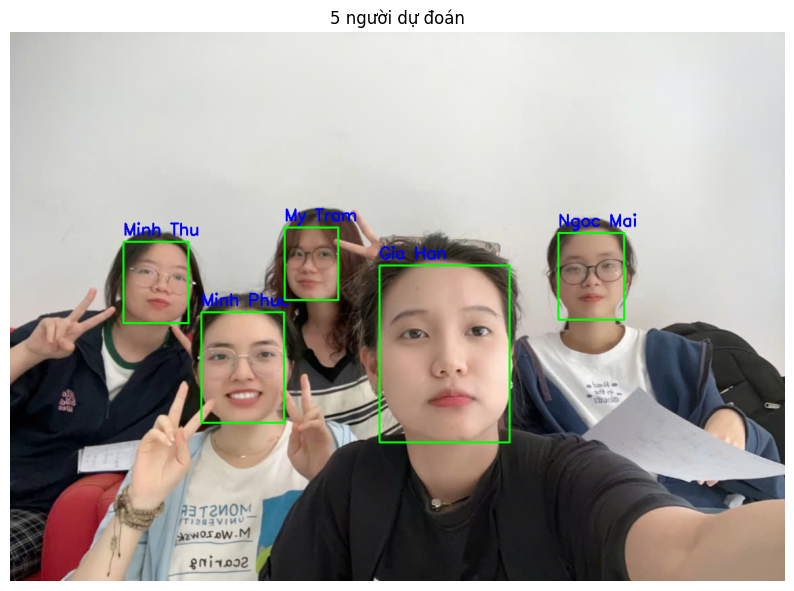

In [50]:
import numpy as np
import cv2
from mtcnn import MTCNN
from tensorflow.keras.models import load_model
from tensorflow.image import resize
import matplotlib.pyplot as plt

# Load mô hình và class names
model = load_model('face_recognition_model.h5')
class_names = np.load('class_names.npy')

# Load ảnh và phát hiện khuôn mặt
image = cv2.imread('pics.jpg')
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
detector = MTCNN()
faces = detector.detect_faces(rgb_image)

print(f"Phát hiện {len(faces)} khuôn mặt")

# Dự đoán từng khuôn mặt
results = []
for i, face in enumerate(faces):
    x, y, w, h = face['box']
    x, y = max(0, x), max(0, y)
    face_crop = rgb_image[y:y+h, x:x+w]

    face_resized = resize(face_crop, (128, 128)) / 255.0
    face_resized = np.expand_dims(face_resized, axis=0)

    pred = model.predict(face_resized)[0]
    results.append({
        'box': (x, y, w, h),
        'probs': pred
    })


used_labels = set()
final_results = []

for r in results:
    sorted_indices = np.argsort(r['probs'])[::-1]
    for idx in sorted_indices:
        label = class_names[idx]
        if label not in used_labels:
            used_labels.add(label)
            final_results.append({
                'box': r['box'],
                'label': label
            })
            break

if len(final_results) < 5:
    for label in class_names:
        if label not in used_labels:
            final_results.append({
                'box': (0, 0, 0, 0),
                'label': label
            })
        if len(final_results) == 5:
            break

for res in final_results:
    x, y, w, h = res['box']
    if w > 0 and h > 0:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image, res['label'], (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

print("5 người dự đoán:", [r['label'] for r in final_results])

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("5 người dự đoán")
plt.show()
